In [3]:
# Importing of necessary libraries
import pandas as pd
import streamlit as st
import seaborn as sns
import matplotlib.pyplot as plt


# Loading of Excel file
excel_file = pd.read_excel('data_source/Twisto_data.xlsx', sheet_name=None)

In [4]:
# Extracting of individual DataFrames
df_base = excel_file['profile_base']
df_customer = excel_file['profile_customer']
df_extension = excel_file['profile_extension']
df_apps = excel_file['profile_apps']
df_transactions = excel_file['profile_transactions']

In [5]:
# Filling in all empty values in df_transaction (column: category)

df_transactions['category'] = df_transactions['category'].fillna('Unknown')

In [6]:
def classify_os(row):
    ios = row['app_ios'] > 0
    android = row['app_android'] > 0
    
    if ios:
        return 'iOS'
    elif android:
        return 'Android'
    elif ios and android:
        return 'Both'
    else:
        return 'Unknown'

# Create new column 'os_type'
df_apps['os_type'] = df_apps.apply(classify_os, axis=1)

# Count unique users by os_type
os_counts = df_apps.groupby('os_type')['user'].nunique()

print(os_counts)

os_type
Android    281
Unknown    427
iOS        292
Name: user, dtype: int64


In [7]:
df_trans_platform = df_transactions.merge(df_apps[['user', 'os_type']], on='user', how='left')

In [8]:
# Number of transactions per user by platform
trans_per_user = (
    df_trans_platform.groupby(['os_type', 'user'])
    .size()
    .reset_index(name='num_transactions')
)

# Average number of transactions per user by platform
avg_trans_per_platform = trans_per_user.groupby('os_type')['num_transactions'].mean()

print("Average transactions per user by platform:\n", avg_trans_per_platform)

# If transaction amounts available (e.g., 'amount' column), do sum and average

if 'amount' in df_transactions.columns:
    amount_stats = (
        df_trans_platform.groupby('os_type')['amount']
        .agg(['sum', 'mean'])
    )
    print("\nTransaction amount stats by platform:\n", amount_stats)

Average transactions per user by platform:
 os_type
Android     92.762846
Unknown     29.151235
iOS        139.646341
Name: num_transactions, dtype: float64


In [9]:
category_counts = (
    df_trans_platform.groupby(['os_type', 'category'])
    .size()
    .unstack(fill_value=0)
)

print("\nTransaction counts by category and platform:\n", category_counts)


Transaction counts by category and platform:
 category  Beauty  Bills And Household   Car  Children  Culture  \
os_type                                                          
Android       63                   28  1089        64      104   
Unknown        6                    4   352        12       21   
iOS          118                   30  2976        99      177   

category  Digital Services  Drugstore  Electronics  Fashion  \
os_type                                                       
Android                756        379           81      497   
Unknown                 86        101           13      111   
iOS                    971        625          224      674   

category  Financial Services  ...  kancelar  knihy  moda  obchodni-dum  \
os_type                       ...                                        
Android                   55  ...         3     65   260            30   
Unknown                    4  ...         5    157   276            25   
iOS       

In [10]:
# Top 10 categories by revenue
top10_revenue = (
    df_transactions.groupby('category')['total_price_vat']
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .index
)

# Top 10 categories by transaction count
top10_count = (
    df_transactions['category']
    .value_counts()
    .head(10)
    .index
)

# Union of both sets so we cover both
top_categories = set(top10_revenue).union(set(top10_count))

In [11]:
# Assume df_apps has app_ios and app_android
def get_platform(row):
    if row['app_ios'] > 0:
        return 'iOS'
    elif row['app_android'] > 0:
        return 'Android'
    else:
        return 'Unknown'

df_apps['platform'] = df_apps.apply(get_platform, axis=1)

# Merge into transactions
df_trans_platform = df_transactions.merge(
    df_apps[['user', 'platform']], 
    on='user', 
    how='left'
)

In [12]:
df_top = df_trans_platform[df_trans_platform['category'].isin(top_categories)]

In [13]:
category_stats = (
    df_top.groupby(['platform', 'category'])
    .agg(
        total_revenue=('total_price_vat', 'sum'),
        transaction_count=('total_price_vat', 'count'),
        avg_transaction_value=('total_price_vat', 'mean')
    )
    .reset_index()
)

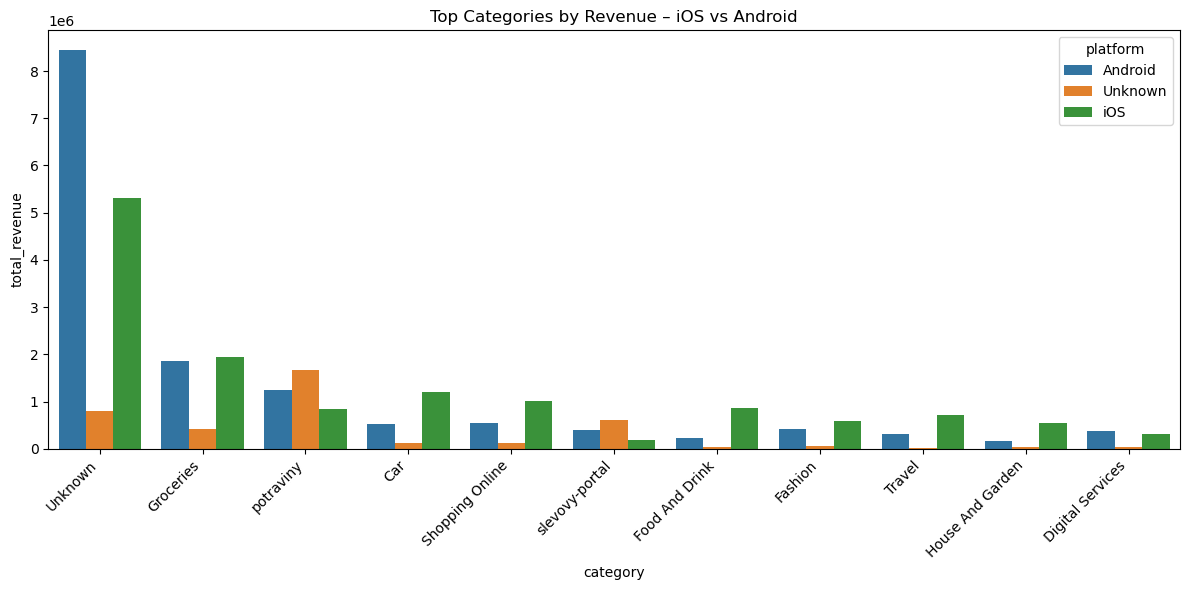

In [14]:
%matplotlib inline
# Sort by revenue in all platforms combined
order = (
    category_stats.groupby('category')['total_revenue']
    .sum()
    .sort_values(ascending=False)
    .index
)

plt.figure(figsize=(12,6))
sns.barplot(
    data=category_stats,
    x='category', 
    y='total_revenue', 
    hue='platform',
    order=order
)
plt.xticks(rotation=45, ha='right')
plt.title('Top Categories by Revenue – iOS vs Android')
plt.tight_layout()
plt.show()